In [1]:
!pip install transformers datasets accelerate evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


In [1]:
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

In [2]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

data_url = f"https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv"
data_name = data_url.split('/')[-1]
print(f'Fetching {data_url}')
with request.urlopen(data_url) as f, open(data_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()

train_labels_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv"
dev_labels_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv"

# Download train_semeval_parids-labels.csv
print(f'Fetching {train_labels_url}')
with request.urlopen(train_labels_url) as f, open('train_semeval_parids-labels.csv','w') as outf:
  outf.write(f.read().decode('utf-8'))

# Download dev_semeval_parids-labels.csv
print(f'Fetching {dev_labels_url}')
with request.urlopen(dev_labels_url) as f, open('dev_semeval_parids-labels.csv','w') as outf:
  outf.write(f.read().decode('utf-8'))

trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)
data=dpm.train_task1_df
data

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py
Fetching https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv
Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv
Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv


,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


Label Counts:
 label
0    9476
1     993
Name: count, dtype: int64


/tmp/ipython-input-3548444837.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='viridis')


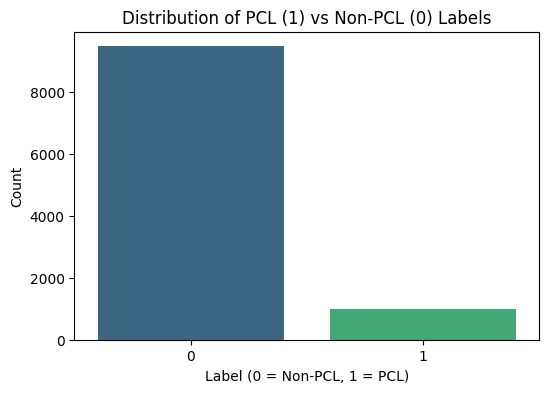

Percentage of PCL examples: 9.49%


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute counts
label_counts = data['label'].value_counts()
print("Label Counts:\n", label_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data, palette='viridis')
plt.title('Distribution of PCL (1) vs Non-PCL (0) Labels')
plt.xlabel('Label (0 = Non-PCL, 1 = PCL)')
plt.ylabel('Count')
plt.show()

# Calculate percentage
pct_positive = (data['label'].sum() / len(data)) * 100
print(f"Percentage of PCL examples: {pct_positive:.2f}%")

Findings: The visualization confirms a severe class imbalance. The dataset is dominated by negative examples (Label 0).
Implication: The "Non-PCL" class represents roughly 90% of the data, meaning a "dummy" classifier that always predicts 0 would achieve ~90% accuracy but 0% recall. Metric Selection: I cannot use Accuracy as my primary metric, as it will be misleadingly high. I must use F1-Score, Precision, and Recall (specifically for the positive class) to correctly evaluate performance.

Training Strategy: I will implement class weights (penalising the model more for missing a positive example) or use stratified splitting for my validation set to ensure the minority class is represented in every fold.

count    10469.000000
mean        48.422485
std         29.091331
min          0.000000
25%         30.000000
50%         42.000000
75%         60.000000
max        909.000000
Name: text_length, dtype: float64


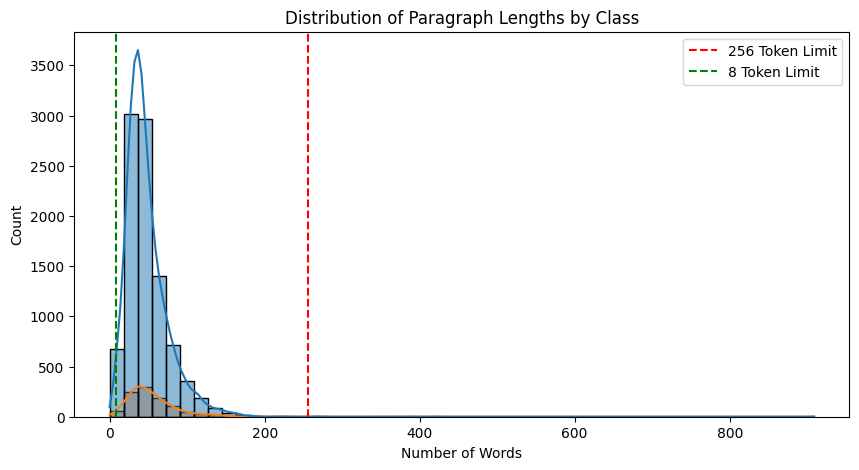

Rows identified as potential noise (< 8 words): 83
                                                  text  label
317                             The Filipino immigrant      0
486  Austria welcomes first migrant buses from Hungary      0
533             Institutions for disabled mull closure      0
590         PM defends record of helping poor families      1
593           Their refugee status remains unchanged !      0
Rows identified as too long (< 256 words): 6
                                                   text  label
292   "The following is a brief history of the Rajne...      0
5977  "Mahinda Wijesinghe , the Inspector General of...      0
6832  "Most are from desperately poor Horn of Africa...      1
7418  "Dr Mayengbam Lalit Singh Recently honourable ...      0
8191  ANNUAL State of Education Report ( ASER ) laun...      0


In [4]:
# 1. Create a length column (approximate token count by splitting on whitespace)
data['text_length'] = data['text'].astype(str).apply(lambda x: len(x.split()))

# 2. Statistics
print(data['text_length'].describe())

# 3. Plot Histograms
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='text_length', hue='label', kde=True, bins=50)
plt.title('Distribution of Paragraph Lengths by Class')
plt.xlabel('Number of Words')
plt.axvline(x=256, color='r', linestyle='--', label='256 Token Limit')
plt.axvline(x=8, color='g', linestyle='--', label='8 Token Limit')
plt.legend()
plt.show()

# 4. Check for noise (very short texts)
noise_threshold = 8  # texts with fewer than 8 words
noise_data = data[data['text_length'] < noise_threshold]
print(f"Rows identified as potential noise (< {noise_threshold} words):", len(noise_data))
print(noise_data[['text', 'label']].head())

upper = 256
upper_data = data[data['text_length'] > upper]
print(f"Rows identified as too long (< {upper} words):", len(upper_data))
print(upper_data[['text', 'label']].head())

Noise Identification: We identified 83 rows with a length of fewer than 8 words. Given that the dataset consists of news paragraphs, these short sequences are likely scraping artifacts (e.g., headers, bylines) rather than meaningful content. They represent less than 1% of the total data. As PCL relies on subtle linguistic markers and tone, these fragments lack sufficient context to be meaningfully labeled and likely constitute noise

Sequence Coverage: The vast majority of the data falls well under 256 tokens. Only 6 paragraphs exceed 256 words. This indicates that a sequence length of 256 will capture the full context for 99.9% of the dataset

Data Cleaning: I will filter out the 83 rows with fewer than 8 words. This removes noise that lacks sufficient context for the "subtle" detection of PCL  without significantly reducing the training volume.

Model Configuration: I will set the BERT tokenizer max_length to 256. This is a computationally efficient choice that covers 99.94% of the dataset. The 6 examples exceeding this length will be truncated, which is an acceptable loss given their rarity.

/tmp/ipython-input-2596439123.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_bigrams_0, x='Frequency', y='Bigram', ax=axes[0], palette='Blues_r')
/tmp/ipython-input-2596439123.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_bigrams_1, x='Frequency', y='Bigram', ax=axes[1], palette='Oranges_r')


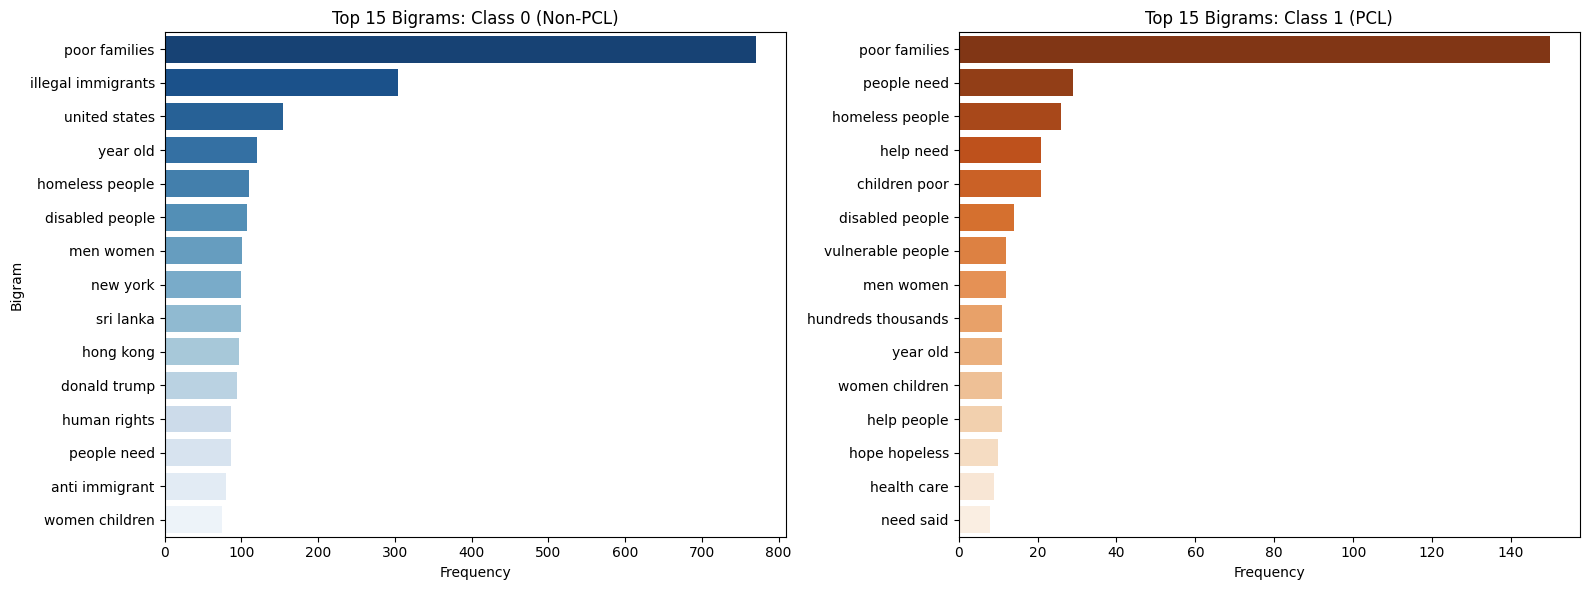

Overlap in top 15 bigrams between classes: 7 terms
Overlapping terms: {'disabled people', 'year old', 'women children', 'homeless people', 'people need', 'poor families', 'men women'}


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

df = data.dropna(subset=['text']).copy()
df['text'] = df['text'].astype(str)

# Function to get top N-grams
def get_top_ngrams(corpus, n=2, top_k=15):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Extract Bigrams for each class (0 = Non-PCL, 1 = PCL)
class_0_text = df[df['label'] == 0]['text']
class_1_text = df[df['label'] == 1]['text']

top_bigrams_0 = get_top_ngrams(class_0_text, n=2, top_k=15)
top_bigrams_1 = get_top_ngrams(class_1_text, n=2, top_k=15)

# Convert to DataFrames for plotting
df_bigrams_0 = pd.DataFrame(top_bigrams_0, columns=['Bigram', 'Frequency'])
df_bigrams_1 = pd.DataFrame(top_bigrams_1, columns=['Bigram', 'Frequency'])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df_bigrams_0, x='Frequency', y='Bigram', ax=axes[0], palette='Blues_r')
axes[0].set_title('Top 15 Bigrams: Class 0 (Non-PCL)')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Bigram')

sns.barplot(data=df_bigrams_1, x='Frequency', y='Bigram', ax=axes[1], palette='Oranges_r')
axes[1].set_title('Top 15 Bigrams: Class 1 (PCL)')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

set_0 = set(df_bigrams_0['Bigram'])
set_1 = set(df_bigrams_1['Bigram'])
overlap = set_0.intersection(set_1)
print(f"Overlap in top 15 bigrams between classes: {len(overlap)} terms")
print(f"Overlapping terms: {overlap}")

In [6]:
# Load Official Split IDs
# Ensure IDs are strings for merging
data['par_id'] = data['par_id'].astype(str)
train_ids_path = "train_semeval_parids-labels.csv"
dev_ids_path = "dev_semeval_parids-labels.csv"
train_ids_df = pd.read_csv(train_ids_path)
dev_ids_df = pd.read_csv(dev_ids_path)

train_ids_df['par_id'] = train_ids_df['par_id'].astype(str)
dev_ids_df['par_id'] = dev_ids_df['par_id'].astype(str)

print(f"Expected Train IDs: {len(train_ids_df)} | Expected Dev IDs: {len(dev_ids_df)}")

# Split data
train_dpm_raw = data[data['par_id'].isin(train_ids_df['par_id'])].copy()
val_dpm = data[data['par_id'].isin(dev_ids_df['par_id'])].copy() # Dev set remains completely untouched!

# Apply length filter ONLY to the training set
train_dpm_raw['text_length'] = train_dpm_raw['text'].astype(str).apply(lambda x: len(x.split()))
min_threshold = 8

train_dpm = train_dpm_raw[train_dpm_raw['text_length'] >= min_threshold].copy()

print(f"Original Train Size: {len(train_dpm_raw)}")
print(f"Cleaned Train Size: {len(train_dpm)}")
print(f"Final Official Val Size: {len(val_dpm)}")

Expected Train IDs: 8375 | Expected Dev IDs: 2094
Original Train Size: 8375
Cleaned Train Size: 8311
Final Official Val Size: 2094


In [7]:
import os
from google.colab import drive
drive.mount('/content/drive')

drive_save_path = "/content/drive/MyDrive/NLP_PCL_Project"
os.makedirs(drive_save_path, exist_ok=True)
print(f"Models will be saved to: {drive_save_path}")

Mounted at /content/drive
Models will be saved to: /content/drive/MyDrive/NLP_PCL_Project


In [ ]:

import glob
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from datasets import Dataset


model_name = "roberta-large"
tapt_save_dir = "/content/drive/MyDrive/NLP_PCL_Project/roberta-large-tapt"

checkpoint_dir = "/content/drive/MyDrive/NLP_PCL_Project/tapt_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)

print("STARTING TASK-ADAPTIVE PRE-TRAINING")


# PREPARE THE UNLABELED DATA
def tokenize_for_mlm(examples):
    inputs = [f"Context: {k}. Text: {t}" for k, t in zip(examples['keyword'], examples['text'])]
    return tokenizer(inputs, max_length=256, truncation=True)

# use the full train_dpm master dataframe
mlm_dataset = Dataset.from_pandas(train_dpm).map(
    tokenize_for_mlm,
    batched=True,
    remove_columns=train_dpm.columns.to_list() # Drop all original text/label columns
)

# add a Language Modelling head on top of RoBERTa
mlm_model = AutoModelForMaskedLM.from_pretrained(model_name)

# randomly mask 15% of the words in every batch for the model to guess
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# TRAINING ARGUMENTS
tapt_args = TrainingArguments(
    output_dir=checkpoint_dir,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    learning_rate=5e-5,
    fp16=True,
    save_strategy="epoch",
    save_total_limit=2,
    logging_strategy="epoch"
)

tapt_trainer = Trainer(
    model=mlm_model,
    args=tapt_args,
    train_dataset=mlm_dataset,
    data_collator=data_collator,
)

if not os.path.exists(tapt_save_dir):
    print("Training MLM...")
    checkpoints = glob.glob(f"{checkpoint_dir}/checkpoint-*")

    if len(checkpoints) > 0:
        print(f"Found existing checkpoints in Drive. Resuming training...")
        tapt_trainer.train(resume_from_checkpoint=True)
    else:
        print("Starting TAPT from scratch...")
        tapt_trainer.train()

    print(f"Saving model to Google Drive: {tapt_save_dir}")
    os.makedirs(tapt_save_dir, exist_ok=True)
    tapt_trainer.save_model(tapt_save_dir)
    tokenizer.save_pretrained(tapt_save_dir)
    print("TAPT Complete")
else:
    print(f"TAPT model already exists at {tapt_save_dir}")

In [10]:
import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_fscore_support
from scipy.special import softmax
from sklearn.utils import shuffle

# Prepends the specific community keyword to the text to provide context
def preprocess_function(examples):
    inputs = [f"Context: {k}. Text: {t}" for k, t in zip(examples['keyword'], examples['text'])]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True)
    model_inputs["labels"] = examples["label"]
    return model_inputs
# use the tapt processed model
#model_name = "roberta-large"
model_name = "/content/drive/MyDrive/NLP_PCL_Project/roberta-large-tapt"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    return {"f1": f1, "precision": precision, "recall": recall}
import torch.nn.functional as F


# IMPLEMENT FOCAL LOSS TRAINER

class FocalLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Focal Loss Implementation
        alpha = 0.75 # Weighting factor for the minority class (PCL)
        gamma = 2.0  # Focusing parameter that down-weights easy examples

        ce_loss = F.cross_entropy(logits.view(-1, self.model.config.num_labels), labels.view(-1), reduction='none')
        pt = torch.exp(-ce_loss)

        # Apply alpha weighting based on the true label
        alpha_t = torch.where(labels.view(-1) == 1, alpha, 1 - alpha)

        focal_loss = (alpha_t * (1 - pt) ** gamma * ce_loss).mean()

        return (focal_loss, outputs) if return_outputs else focal_loss

# CROSS-VALIDATION LOOP

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_dpm, train_dpm['label'])):
    print(f"\n--- Training Fold {fold+1} ---")

    train_fold = Dataset.from_pandas(train_dpm.iloc[train_idx]).map(preprocess_function, batched=True)
    val_fold = Dataset.from_pandas(train_dpm.iloc[val_idx]).map(preprocess_function, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    # PARTIAL LAYER FREEZING (Bottom 12 layers)
    modules_to_freeze = [model.roberta.embeddings] + list(model.roberta.encoder.layer[:12])

    for module in modules_to_freeze:
        for param in module.parameters():
            param.requires_grad = False

    # TARGETED REGULARIZATION: 20% Dropout ONLY on top 12 layers & classifier
    # Iterate through the trainable layers (12 to 23)
    for layer in model.roberta.encoder.layer[12:]:
        for module in layer.modules():
            if isinstance(module, nn.Dropout):
                module.p = 0.2

    for module in model.classifier.modules():
        if isinstance(module, nn.Dropout):
            module.p = 0.2
    print("Bottom 12 layers frozen, dropout on top 12 layers")

    training_args = TrainingArguments(
        output_dir=f"./colab_fold_{fold+1}",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,  # Keep effective batch size at 16
        fp16=True,
        warmup_ratio=0.1,
        logging_strategy="epoch",
        num_train_epochs=4,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )

    trainer = FocalLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_fold,
        eval_dataset=val_fold,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer),
    )

    trainer.train()

    # Save model for this fold to Google Drive
    fold_save_path = os.path.join(drive_save_path, f"roberta_fold_{fold+1}")
    print(f"Saving best model for fold {fold+1} to {fold_save_path}...")
    trainer.save_model(fold_save_path)
    tokenizer.save_pretrained(fold_save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models will be saved to: /content/drive/MyDrive/NLP_PCL_Project

--- Training Fold 1 ---


Map:   0%|          | 0/6648 [00:00<?, ? examples/s]

Map:   0%|          | 0/1663 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: /content/drive/MyDrive/NLP_PCL_Project/roberta-large-tapt
Key                        | Status     | 
---------------------------+------------+-
lm_head.layer_norm.bias    | UNEXPECTED | 
lm_head.dense.weight       | UNEXPECTED | 
lm_head.bias               | UNEXPECTED | 
lm_head.layer_norm.weight  | UNEXPECTED | 
lm_head.dense.bias         | UNEXPECTED | 
classifier.dense.weight    | MISSING    | 
classifier.out_proj.weight | MISSING    | 
classifier.out_proj.bias   | MISSING    | 
classifier.dense.bias      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Bottom 12 layers frozen, dropout on top 12 layers


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.097386,0.026835,0.510843,0.414062,0.666667
2,0.073455,0.044444,0.495798,0.746835,0.371069
3,0.050597,0.035675,0.576389,0.643411,0.522013
4,0.034457,0.038559,0.627329,0.619632,0.635220


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

Saving best model for fold 1 to /content/drive/MyDrive/NLP_PCL_Project/roberta_fold_1...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


--- Training Fold 2 ---


Map:   0%|          | 0/6649 [00:00<?, ? examples/s]

Map:   0%|          | 0/1662 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: /content/drive/MyDrive/NLP_PCL_Project/roberta-large-tapt
Key                        | Status     | 
---------------------------+------------+-
lm_head.layer_norm.bias    | UNEXPECTED | 
lm_head.dense.weight       | UNEXPECTED | 
lm_head.bias               | UNEXPECTED | 
lm_head.layer_norm.weight  | UNEXPECTED | 
lm_head.dense.bias         | UNEXPECTED | 
classifier.dense.weight    | MISSING    | 
classifier.out_proj.weight | MISSING    | 
classifier.out_proj.bias   | MISSING    | 
classifier.dense.bias      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Bottom 12 layers frozen, dropout on top 12 layers


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.092163,0.025460,0.558824,0.521978,0.601266
2,0.067984,0.027723,0.611111,0.596386,0.626582
3,0.046963,0.033618,0.593472,0.558659,0.632911
4,0.029787,0.041658,0.603659,0.582353,0.626582


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

Saving best model for fold 2 to /content/drive/MyDrive/NLP_PCL_Project/roberta_fold_2...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


--- Training Fold 3 ---


Map:   0%|          | 0/6649 [00:00<?, ? examples/s]

Map:   0%|          | 0/1662 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: /content/drive/MyDrive/NLP_PCL_Project/roberta-large-tapt
Key                        | Status     | 
---------------------------+------------+-
lm_head.layer_norm.bias    | UNEXPECTED | 
lm_head.dense.weight       | UNEXPECTED | 
lm_head.bias               | UNEXPECTED | 
lm_head.layer_norm.weight  | UNEXPECTED | 
lm_head.dense.bias         | UNEXPECTED | 
classifier.dense.weight    | MISSING    | 
classifier.out_proj.weight | MISSING    | 
classifier.out_proj.bias   | MISSING    | 
classifier.dense.bias      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Bottom 12 layers frozen, dropout on top 12 layers


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.106611,0.043872,0.356902,0.381295,0.335443
2,0.086288,0.047750,0.475113,0.369718,0.664557
3,0.066691,0.036315,0.506849,0.552239,0.468354
4,0.052979,0.036396,0.535484,0.546053,0.525316


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

Saving best model for fold 3 to /content/drive/MyDrive/NLP_PCL_Project/roberta_fold_3...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


--- Training Fold 4 ---


Map:   0%|          | 0/6649 [00:00<?, ? examples/s]

Map:   0%|          | 0/1662 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: /content/drive/MyDrive/NLP_PCL_Project/roberta-large-tapt
Key                        | Status     | 
---------------------------+------------+-
lm_head.layer_norm.bias    | UNEXPECTED | 
lm_head.dense.weight       | UNEXPECTED | 
lm_head.bias               | UNEXPECTED | 
lm_head.layer_norm.weight  | UNEXPECTED | 
lm_head.dense.bias         | UNEXPECTED | 
classifier.dense.weight    | MISSING    | 
classifier.out_proj.weight | MISSING    | 
classifier.out_proj.bias   | MISSING    | 
classifier.dense.bias      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Bottom 12 layers frozen, dropout on top 12 layers


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.095228,0.033777,0.497487,0.412500,0.626582
2,0.067703,0.035811,0.548105,0.508108,0.594937
3,0.045676,0.040924,0.574132,0.572327,0.575949
4,0.030769,0.052091,0.567742,0.578947,0.556962


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

Saving best model for fold 4 to /content/drive/MyDrive/NLP_PCL_Project/roberta_fold_4...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


--- Training Fold 5 ---


Map:   0%|          | 0/6649 [00:00<?, ? examples/s]

Map:   0%|          | 0/1662 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: /content/drive/MyDrive/NLP_PCL_Project/roberta-large-tapt
Key                        | Status     | 
---------------------------+------------+-
lm_head.layer_norm.bias    | UNEXPECTED | 
lm_head.dense.weight       | UNEXPECTED | 
lm_head.bias               | UNEXPECTED | 
lm_head.layer_norm.weight  | UNEXPECTED | 
lm_head.dense.bias         | UNEXPECTED | 
classifier.dense.weight    | MISSING    | 
classifier.out_proj.weight | MISSING    | 
classifier.out_proj.bias   | MISSING    | 
classifier.dense.bias      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Bottom 12 layers frozen, dropout on top 12 layers


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.088728,0.046971,0.534296,0.621849,0.468354
2,0.068509,0.040218,0.558304,0.632000,0.500000
3,0.046889,0.028146,0.587629,0.495652,0.721519
4,0.032253,0.040771,0.635838,0.585106,0.696203


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

Saving best model for fold 5 to /content/drive/MyDrive/NLP_PCL_Project/roberta_fold_5...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
import os
import torch
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, DataCollatorWithPadding
from sklearn.metrics import precision_recall_fscore_support
from scipy.special import softmax

print("RUNNING FINAL ENSEMBLE VALIDATION")

# preprocess the untouched official validation set
val_dataset = Dataset.from_pandas(val_dpm).map(preprocess_function, batched=True)

# Array to store the sum of predicted probabilities from all 5 models
ensemble_probs = np.zeros((len(val_dataset), 2))

# Loop through the saved RoBERTa models in Google Drive
for fold in range(1, 6):
    print(f"Loading and predicting with model from Fold {fold}...")
    fold_path = os.path.join(drive_save_path, f"roberta_fold_{fold}")

    fold_model = AutoModelForSequenceClassification.from_pretrained(fold_path)
    fold_tokenizer = AutoTokenizer.from_pretrained(fold_path)

    fold_trainer = Trainer(
        model=fold_model,
        data_collator=DataCollatorWithPadding(fold_tokenizer)
    )

    # Predict on the validation set
    preds = fold_trainer.predict(val_dataset)

    # Convert raw logits to probabilities and add to our running total
    probs = softmax(preds.predictions, axis=-1)
    ensemble_probs += probs

# Average the probabilities across the 5 models
avg_probs = ensemble_probs / 5.0

# If the averaged probability for Class 1 (PCL) is >= 50%
final_binary_preds = (avg_probs[:, 1] >= 0.5).astype(int)

# Calculate final official metrics
true_binary_labels = val_dpm['label'].values
precision, recall, f1, _ = precision_recall_fscore_support(
    true_binary_labels, final_binary_preds, average='binary', zero_division=0
)


print("FINAL ENSEMBLE PERFORMANCE (val_dpm)")
print(f" F1 Score:  {f1:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")

with open("dev.txt", "w") as f:
    for pred in final_binary_preds:
        f.write(f"{pred}\n")
print("Saved dev.txt successfully!")

RUNNING FINAL ENSEMBLE VALIDATION


Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

Loading and predicting with model from Fold 1...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Loading and predicting with model from Fold 2...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Loading and predicting with model from Fold 3...


Loading weights:   0%|          | 0/393 [00:01<?, ?it/s]

Loading and predicting with model from Fold 4...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Loading and predicting with model from Fold 5...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

FINAL ENSEMBLE PERFORMANCE (val_dpm)
 F1 Score:  0.6076
 Precision: 0.6122
 Recall:    0.6030
Saved dev.txt successfully!


In [12]:
test_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv"
print(f'Fetching {test_url} ...')
with request.urlopen(test_url) as f, open('task4_test.tsv', 'w', encoding='utf-8') as outf:
    outf.write(f.read().decode('utf-8'))

# Read the TSV file.
test_df = pd.read_csv('task4_test.tsv', sep='\t', header=None,
                      names=['par_id', 'art_id', 'keyword', 'country', 'text'],
                      quoting=3)

# Handle any potential NaNs in the text or keyword columns
test_df['text'] = test_df['text'].fillna('')
test_df['keyword'] = test_df['keyword'].fillna('')

print(f"Loaded Test Set. Size: {len(test_df)}")

# PREPROCESS TEST SET
# Load tokenizer from fold 1  to map the dataset
tokenizer = AutoTokenizer.from_pretrained(os.path.join(drive_save_path, "roberta_fold_1"))

def preprocess_test_function(examples):
    inputs = [f"Context: {k}. Text: {t}" for k, t in zip(examples['keyword'], examples['text'])]
    return tokenizer(inputs, max_length=256, truncation=True)

test_dataset = Dataset.from_pandas(test_df).map(preprocess_test_function, batched=True)

# RUN ENSEMBLE PREDICTION ON TEST SET
print("RUNNING FINAL ENSEMBLE PREDICTION ON TEST SET")

test_ensemble_probs = np.zeros((len(test_dataset), 2))

for fold in range(1, 6):
    print(f"Predicting with model from Fold {fold}...")
    fold_path = os.path.join(drive_save_path, f"roberta_fold_{fold}")

    fold_model = AutoModelForSequenceClassification.from_pretrained(fold_path)
    fold_tokenizer = AutoTokenizer.from_pretrained(fold_path)

    fold_trainer = Trainer(
        model=fold_model,
        data_collator=DataCollatorWithPadding(fold_tokenizer)
    )

    # Predict on the test set
    preds = fold_trainer.predict(test_dataset)

    # Convert raw logits to probabilities and add to running total
    probs = softmax(preds.predictions, axis=-1)
    test_ensemble_probs += probs

# Average the probabilities across the 5 models
avg_test_probs = test_ensemble_probs / 5.0

final_test_preds = (avg_test_probs[:, 1] >= 0.5).astype(int)

# SAVE TEST SET PREDICTIONS
with open("test.txt", "w") as f:
    for pred in final_test_preds:
        f.write(f"{pred}\n")

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv ...
Loaded Test Set. Size: 3832


Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

RUNNING FINAL ENSEMBLE PREDICTION ON TEST SET
Predicting with model from Fold 1...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Predicting with model from Fold 2...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Predicting with model from Fold 3...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Predicting with model from Fold 4...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Predicting with model from Fold 5...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay, average_precision_score

print("STARTING LOCAL EVALUATION")

# combine the original validation text, keywords, true labels, and our model's predictions
analysis_df = val_dpm.copy()
analysis_df['true_label'] = analysis_df['label'].values
analysis_df['pred_label'] = final_binary_preds
analysis_df['pcl_probability'] = avg_probs[:, 1] # The ensemble's confidence that it is PCL

# ERROR ANALYSIS

# False Positives: Model predicted PCL (1), but actual is No PCL (0)
false_positives = analysis_df[(analysis_df['true_label'] == 0) & (analysis_df['pred_label'] == 1)]

# False Negatives: Model predicted No PCL (0), but actual is PCL (1)
false_negatives = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['pred_label'] == 0)]

print(f"Total Validation Examples: {len(analysis_df)}")
print(f"False Positives (Over-predicted PCL): {len(false_positives)}")
print(f"False Negatives (Missed PCL): {len(false_negatives)}")

false_positives[['keyword', 'text', 'pcl_probability']].to_csv("error_analysis_false_positives.csv", index=False)
false_negatives[['keyword', 'text', 'pcl_probability']].to_csv("error_analysis_false_negatives.csv", index=False)

# Quick look at which keywords cause the most errors
print("\nTop Keywords causing False Positives:")
print(false_positives['keyword'].value_counts().head(10))

print("\nTop Keywords causing False Negatives:")
print(false_negatives['keyword'].value_counts().head(10))


# CUSTOM METRICS (Visualizations)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(analysis_df['true_label'], analysis_df['pred_label'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No PCL (0)', 'PCL (1)'],
            yticklabels=['No PCL (0)', 'PCL (1)'])
axes[0].set_title('Confusion Matrix: Final Ensemble')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Precision-Recall Curve

# A PR curve shows the trade-off between precision and recall for different thresholds.
# It is highly preferred over ROC curves for imbalanced datasets.
avg_precision = average_precision_score(analysis_df['true_label'], analysis_df['pcl_probability'])
PrecisionRecallDisplay.from_predictions(
    analysis_df['true_label'],
    analysis_df['pcl_probability'],
    ax=axes[1],
    name="Ensemble Model",
    color="darkorange"
)
axes[1].set_title(f'Precision-Recall Curve (AUC = {avg_precision:.3f})')

plt.tight_layout()
plt.savefig("local_evaluation_metrics.png", dpi=300)
plt.show()

print("Saved error analysis CSVs and custom metrics visualization")

STARTING LOCAL EVALUATION
Total Validation Examples: 2094
False Positives (Over-predicted PCL): 76
False Negatives (Missed PCL): 79

Top Keywords causing False Positives:
keyword
hopeless         15
in-need          14
homeless         11
poor-families    11
vulnerable       11
refugee           9
disabled          3
women             2
Name: count, dtype: int64

Top Keywords causing False Negatives:
keyword
poor-families    19
women            12
hopeless         11
homeless         11
disabled          6
vulnerable        6
refugee           5
immigrant         4
in-need           3
migrant           2
Name: count, dtype: int64


In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


with open("dev.txt", "r", encoding="utf-8") as f:
    loaded_preds = [int(line.strip()) for line in f.readlines()]

final_binary_preds = np.array(loaded_preds)

analysis_df = val_dpm.copy()
analysis_df['true_label'] = analysis_df['label'].values
analysis_df['pred_label'] = final_binary_preds

false_positives = analysis_df[(analysis_df['true_label'] == 0) & (analysis_df['pred_label'] == 1)]
false_negatives = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['pred_label'] == 0)]

print(f"Successfully loaded {len(final_binary_preds)} predictions.")
print(f"False Positives found: {len(false_positives)}")
print(f"False Negatives found: {len(false_negatives)}")

print("\n--- 5 FALSE POSITIVES (Model predicted PCL, but it is No PCL) ---")
for idx, row in false_positives.head(5).iterrows():
    print(f"Keyword: {row['keyword']}")
    print(f"Text: {row['text']}\n")

print("--- 5 FALSE NEGATIVES (Model missed actual PCL) ---")
for idx, row in false_negatives.head(5).iterrows():
    print(f"Keyword: {row['keyword']}")
    print(f"Text: {row['text']}\n")

Successfully loaded 2094 predictions.
False Positives found: 76
False Negatives found: 79

--- 5 FALSE POSITIVES (Model predicted PCL, but it is No PCL) ---
Keyword: poor-families
Text: Marcos said the government should help poor families that try every possible means to survive . With Joel Zurbano <h> More from this Category :

Keyword: hopeless
Text: """ So we do need to heal ourselves as an Aboriginal Torres Strait islander community , but also as a nation . "" <h> A life of hope , not hopelessness"

Keyword: women
Text: """ The government needs to come forward , and it needs to give resources to legal aid , so that those women and those families have their basic human rights and safety met , around representation and justice , the ability to navigate that Goliath of an office with a great deal of power , and to ensure they have the education and the advocacy that they need . "" <h> Child and Youth Advocate responds"

Keyword: homeless
Text: "On Oct. 1 , at the Working America blog 

In [ ]:
import numpy as np

print("RUNNING ADVANCED LOCAL EVALUATION")

#KEYWORD-LEVEL ERROR BREAKDOWN

# Create a column to categorize the prediction outcome
conditions = [
    (analysis_df['true_label'] == 1) & (analysis_df['pred_label'] == 1), # True Positive
    (analysis_df['true_label'] == 0) & (analysis_df['pred_label'] == 0), # True Negative
    (analysis_df['true_label'] == 0) & (analysis_df['pred_label'] == 1), # False Positive
    (analysis_df['true_label'] == 1) & (analysis_df['pred_label'] == 0)  # False Negative
]
choices = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
analysis_df['outcome'] = np.select(conditions, choices, default='Unknown')

# Group by keyword and outcome
keyword_errors = analysis_df[analysis_df['outcome'].isin(['False Positive', 'False Negative'])]
keyword_counts = keyword_errors.groupby(['keyword', 'outcome']).size().unstack(fill_value=0)


# Plotting Keyword Errors
plt.figure(figsize=(12, 6))
keyword_counts.plot(kind='bar', stacked=True, color=['#e74c3c', '#f39c12'], ax=plt.gca())
plt.title('Classification Errors strictly by Dataset Keyword')
plt.ylabel('Number of Errors')
plt.xlabel('Keyword Category')
plt.xticks(rotation=45)
plt.legend(title='Error Type')
plt.tight_layout()
plt.savefig("keyword_error_breakdown.png", dpi=300)
plt.show()

# CONFIDENCE (CALIBRATION) DISTRIBUTION
# Separate probabilities for correct vs incorrect predictions
correct_probs = analysis_df[analysis_df['true_label'] == analysis_df['pred_label']]['pcl_probability']
incorrect_probs = analysis_df[analysis_df['true_label'] != analysis_df['pred_label']]['pcl_probability']


# Plotting Confidence Histogram
plt.figure(figsize=(10, 6))
sns.histplot(correct_probs, bins=20, color='green', alpha=0.5, label='Correct Predictions', stat='density')
sns.histplot(incorrect_probs, bins=20, color='red', alpha=0.5, label='Incorrect Predictions', stat='density')
plt.axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold (0.5)')
plt.title('Model Confidence Distribution: Correct vs. Incorrect Predictions')
plt.xlabel('Predicted Probability of being PCL (Class 1)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig("confidence_distribution.png", dpi=300)
plt.show()

print("Saved advanced evaluation visuals!")